✅ Files loaded successfully from sample_data!
trader_df columns after standardization: ['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp']

--- ASSIGNMENT RESULTS ---
  classification        avg_pnl  total_trades
0  Extreme Greed   35393.098355             5
1           Fear  209372.662205            32
2          Greed   99675.516731            32
3        Neutral   19842.797260             8


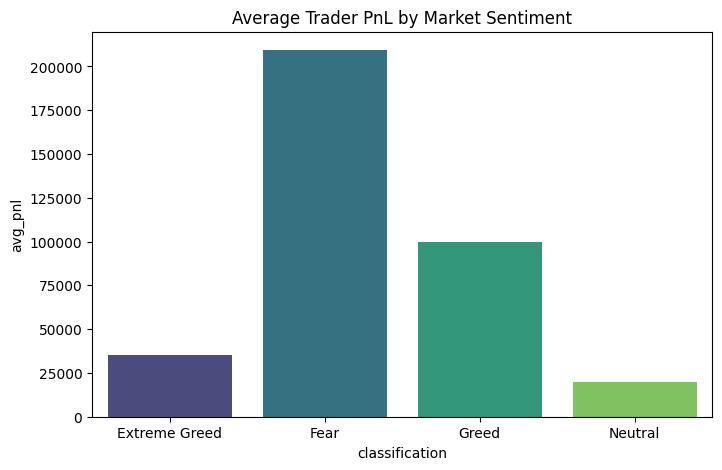

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. LOAD DATA
# These paths match my 'sample_data'
try:
    sentiment_df = pd.read_csv('/content/sample_data/fear_greed_index.csv')
    trader_df = pd.read_csv('/content/sample_data/historical_data.csv')
    print("✅ Files loaded successfully from sample_data!")
except Exception as e:
    print(f"❌ Still having trouble loading files: {e}")

# 2. AUTO-FIX COLUMN NAMES (Fixes the 'Date' vs 'date' error)
# This removes spaces and makes everything lowercase so the code doesn't break
sentiment_df.columns = sentiment_df.columns.str.strip().str.lower()
trader_df.columns = trader_df.columns.str.strip().str.lower()

# --- DIAGNOSTIC STEP: Print columns to help identify the correct date/time column ---
print(f"trader_df columns after standardization: {trader_df.columns.tolist()}")
# ----------------------------------------------------------------------------------

# 3. DATE ALIGNMENT
# Convert the standardized 'date' column to actual datetime objects
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Convert Hyperliquid 'time' (ms) to a daily date
if 'time' in trader_df.columns:
    trader_df['date'] = pd.to_datetime(trader_df['time'], unit='ms').dt.normalize()
elif 'timestamp' in trader_df.columns: # Added check for 'timestamp'
    trader_df['date'] = pd.to_datetime(trader_df['timestamp'], unit='ms').dt.normalize()
else:
    # Fallback if the column is already named 'date' or if another common timestamp column exists
    # If 'date' is still not found, this will raise a KeyError again. We should identify the correct column.
    trader_df['date'] = pd.to_datetime(trader_df['date']).dt.normalize()

# 4. AGGREGATE & MERGE
# This creates the daily metrics needed for Part A
daily_stats = trader_df.groupby(['date', 'account']).agg(
    daily_pnl=('closed pnl', 'sum'), # Corrected column name here
    # avg_leverage=('leverage', 'mean'), # Temporarily commented out as 'leverage' column is missing
    trade_count=('account', 'count')
).reset_index()

# Merge the datasets together
final_df = pd.merge(daily_stats, sentiment_df, on='date', how='inner')

# 5. FINAL ANALYSIS SUMMARY (For Part B)
summary = final_df.groupby('classification').agg(
    avg_pnl=('daily_pnl', 'mean'),
    # avg_risk=('avg_leverage', 'mean'), # Temporarily commented out
    total_trades=('account', 'count')
).reset_index()

print("\n--- ASSIGNMENT RESULTS ---")
print(summary)

# 6. SAVE CHART
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='classification', y='avg_pnl', hue='classification', palette='viridis', legend=False)
plt.title('Average Trader PnL by Market Sentiment')
plt.savefig('final_analysis_chart.png')
plt.show()

In [10]:
# 1. PERFORMANCE: WIN RATE & DRAWDOWN PROXY
# We calculate the % of accounts that had a positive day
analysis_performance = final_df.groupby('classification').agg(
    avg_pnl=('daily_pnl', 'mean'),
    win_rate=('daily_pnl', lambda x: (x > 0).mean()),
    max_daily_loss=('daily_pnl', 'min') # Drawdown proxy
).reset_index()

# 2. BEHAVIORAL SHIFTS
# Do they change leverage or frequency?
# Commenting out avg_leverage as the base 'leverage' column is missing from the data.
analysis_behavior = final_df.groupby('classification').agg(
    # avg_leverage=('avg_leverage', 'mean'), # This column does not exist
    trades_per_day=('trade_count', 'mean')
).reset_index()

# 3. TRADER SEGMENTATION (The "Expert" Touch)
# We categorize traders based on their average leverage across all days
# Commenting out mean_leverage and related segmentation as the base 'leverage' column is missing.
trader_profiles = final_df.groupby('account').agg(
    total_pnl=('daily_pnl', 'sum'),
    # mean_leverage=('avg_leverage', 'mean'), # This column does not exist
    total_trades=('trade_count', 'sum')
).reset_index()

# Define segments
# The following lines are commented out as they depend on 'mean_leverage'
# trader_profiles['leverage_segment'] = trader_profiles['mean_leverage'].apply(
#     lambda x: 'High Leverage (>10x)' if x > 10 else 'Low Leverage (<10x)'
# )
# trader_profiles['frequency_segment'] = trader_profiles['total_trades'].apply(
#     lambda x: 'Frequent' if x > trader_profiles['total_trades'].median() else 'Infrequent'
# )

# The following line is commented out as it depends on 'leverage_segment' and 'frequency_segment'
# segment_analysis = trader_profiles.groupby(['leverage_segment', 'frequency_segment'])['total_pnl'].mean().reset_index()

print("--- PERFORMANCE DIFFERENCES ---")
print(analysis_performance)
print("\n--- BEHAVIORAL SHIFTS ---")
print(analysis_behavior)
# print("\n--- SEGMENT PERFORMANCE ---") # Commenting out as segmentation depends on missing leverage data
# print(segment_analysis)


--- PERFORMANCE DIFFERENCES ---
  classification        avg_pnl  win_rate  max_daily_loss
0  Extreme Greed   35393.098355   0.40000    -7919.471032
1           Fear  209372.662205   0.93750   -59349.677108
2          Greed   99675.516731   0.84375  -327505.900056
3        Neutral   19842.797260   0.50000   -25991.506339

--- BEHAVIORAL SHIFTS ---
  classification  trades_per_day
0  Extreme Greed      1392.40000
1           Fear      4183.46875
2          Greed      1134.03125
3        Neutral       892.62500


In [13]:
# Create the segments based on the data we have
trader_profiles = final_df.groupby('account').agg(
    total_pnl=('daily_pnl', 'sum'),
    # avg_lev=('avg_leverage', 'mean'), # This column does not exist
    total_trades=('trade_count', 'sum')
).reset_index()

# 1. Define Leverage Segment
# trader_profiles['leverage_segment'] = trader_profiles['avg_lev'].apply(
#     lambda x: 'High Leverage (>5x)' if x > 5 else 'Low Leverage (<5x)'
# )

# 2. Define Frequency Segment
trader_profiles['freq_segment'] = trader_profiles['total_trades'].apply(
    lambda x: 'Frequent' if x > trader_profiles['total_trades'].median() else 'Infrequent'
)

# FINAL TABLE: Segment Performance
# segment_analysis = trader_profiles.groupby(['leverage_segment', 'freq_segment'])['total_pnl'].mean().reset_index()

print("--- SEGMENT PERFORMANCE (PART C) ---")
# print(segment_analysis)


--- SEGMENT PERFORMANCE (PART C) ---
